In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import r2_score

import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt

sns.set( rc={'figure.figsize':(16,9)} )

# Choose stocks and market
# Fix Risk Parameter

In [2]:
chosen_ones = [
                'Titan', 'ASIANPAINT',      # Consumer Durables
                'HINDUNILVR', 'ITC',        # FMCG
                'APOLLOHOSP',               # Healthcare
                'HDFCBANK', 'HDFC'          # Financial Services
            ]

index_one = '^NSEI'                         # NIFTY 50

# Download data

In [3]:
history = {}

yf.pdr_override( )
history[index_one] = pdr.get_data_yahoo( index_one, period='3y' ).reset_index( )

good_dates = set( history[index_one]['Date'] )

history[index_one].shape

[*********************100%***********************]  1 of 1 completed


(745, 7)

In [4]:
for ticker in chosen_ones:
    history[ticker] = pdr.get_data_yahoo( ticker + '.NS', period='3y' ).reset_index( )
    print( ticker + ': ' + str( history[ticker].shape ) )

    good_dates = good_dates.intersection( set( history[ticker]['Date'] ) )

[*********************100%***********************]  1 of 1 completed
Titan: (747, 7)
[*********************100%***********************]  1 of 1 completed
ASIANPAINT: (747, 7)
[*********************100%***********************]  1 of 1 completed
HINDUNILVR: (747, 7)
[*********************100%***********************]  1 of 1 completed
ITC: (747, 7)
[*********************100%***********************]  1 of 1 completed
APOLLOHOSP: (747, 7)
[*********************100%***********************]  1 of 1 completed
HDFCBANK: (747, 7)
[*********************100%***********************]  1 of 1 completed
HDFC: (747, 7)


# Get rid of dates with missing data

In [5]:
for key in history.keys( ):
    history[key] = history[key][ history[key]['Date'].isin( good_dates ) ].reset_index( drop=True )
    print( key + ': ' + str( history[key].shape ) )

^NSEI: (745, 7)
Titan: (745, 7)
ASIANPAINT: (745, 7)
HINDUNILVR: (745, 7)
ITC: (745, 7)
APOLLOHOSP: (745, 7)
HDFCBANK: (745, 7)
HDFC: (745, 7)


# Calculate Daily Return

In [6]:
for key in history.keys( ):
    history[key]['Return'] = ( history[key]['Close'] - history[key]['Close'].shift( 1 ) ) / history[key]['Open']
    history[key].dropna( inplace=True )
    history[key].reset_index ( drop=True, inplace=True )

# Train test split

In [7]:
split_date = history[index_one]['Date'].max( ) - dt.timedelta( days=180 )
split_date

Timestamp('2022-04-16 00:00:00+0530', tz='Asia/Kolkata')

In [8]:
test_history = {}
train_history = {}

for key in history.keys( ):
    train_history[key] = history[key][ history[key]['Date'] < split_date ].copy( )
    test_history[key] = history[key][ history[key]['Date'] >= split_date ].copy( )

# Calculate Expected Return and Standard Deviation

In [9]:
train_exp_return = {}
train_std_return = {}

for key in train_history.keys( ):
    train_exp_return[key] = train_history[key]['Return'].mean( )
    train_std_return[key] = train_history[key]['Return'].std( )

In [10]:
test_exp_return = {}
test_std_return = {}

for key in test_history.keys( ):
    test_exp_return[key] = test_history[key]['Return'].mean( )
    test_std_return[key] = test_history[key]['Return'].std( )

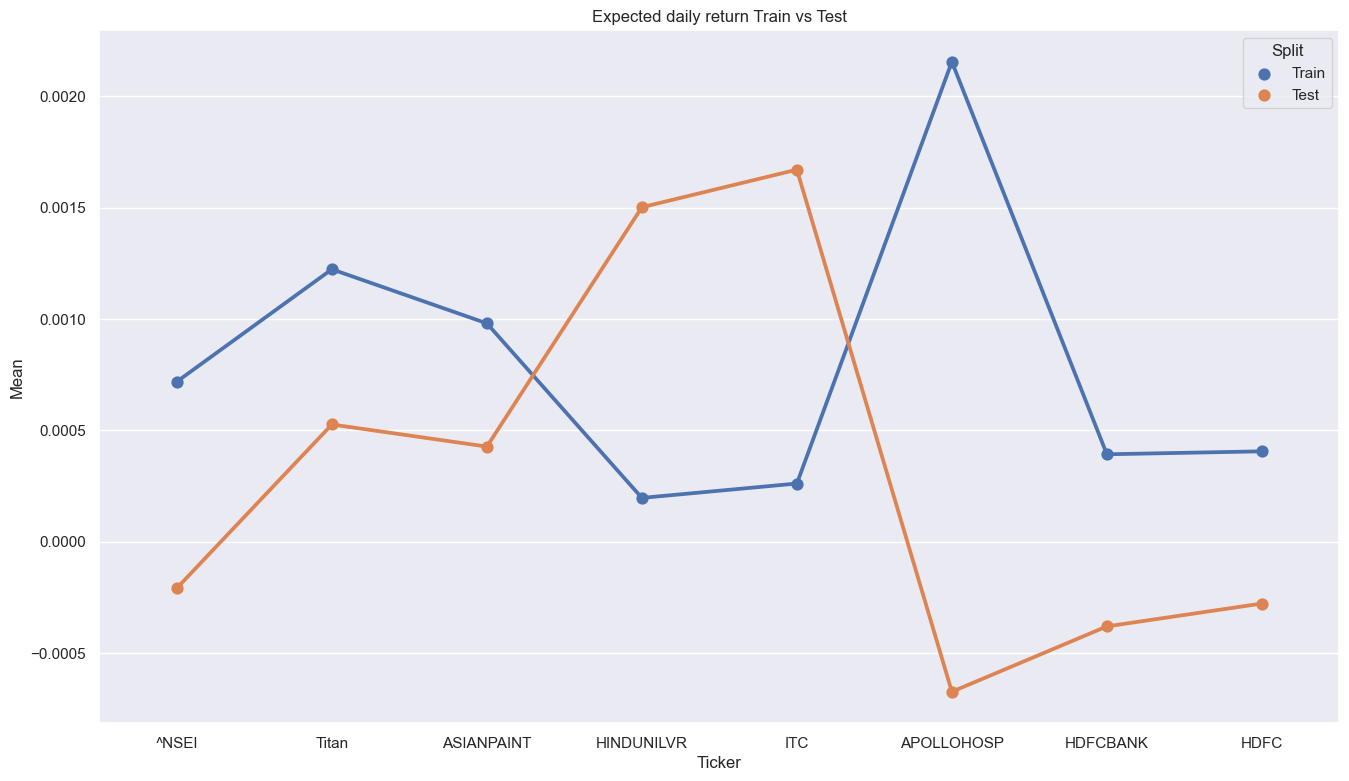

In [11]:
exp_return_graph = pd.concat( [
pd.DataFrame( list( zip( ['Train'] * len( train_exp_return.keys( ) ), train_exp_return.keys( ), train_exp_return.values( ) ) ), columns=['Split', 'Ticker', 'Mean'] ),
pd.DataFrame( list( zip( ['Test'] * len( test_exp_return.keys( ) ), test_exp_return.keys( ), test_exp_return.values( ) ) ), columns=['Split', 'Ticker', 'Mean'] )
] )

fig = sns.pointplot( data=exp_return_graph, x='Ticker', y='Mean', hue='Split' )
plt.title( 'Expected daily return Train vs Test' )
plt.show( )

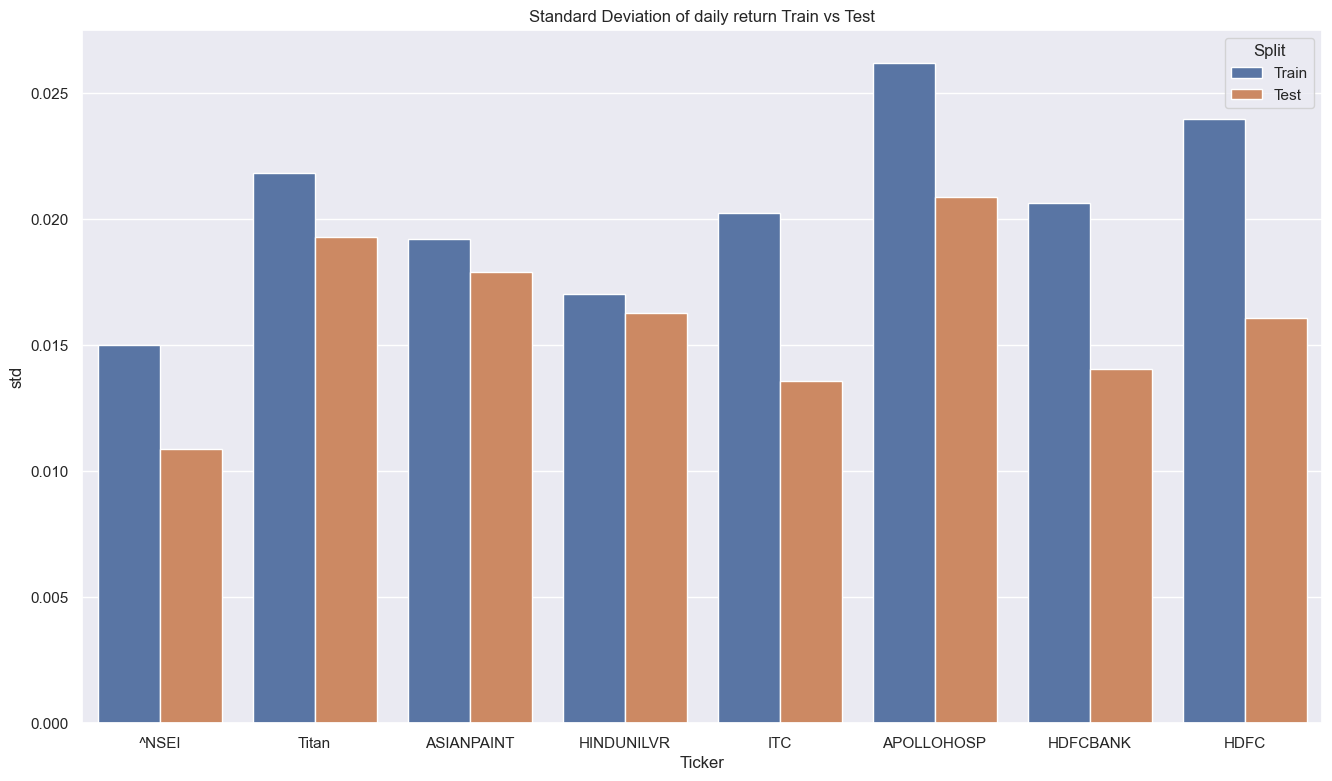

In [12]:
std_return_graph = pd.concat( [
pd.DataFrame( list( zip( ['Train'] * len( train_std_return.keys( ) ), train_std_return.keys( ), train_std_return.values( ) ) ), columns=['Split', 'Ticker', 'std'] ),
pd.DataFrame( list( zip( ['Test'] * len( test_std_return.keys( ) ), test_std_return.keys( ), test_std_return.values( ) ) ), columns=['Split', 'Ticker', 'std'] )
] )

# fig = sns.pointplot( data=std_return_graph, x='Ticker', y='std', hue='Split' )
sns.barplot( data=std_return_graph, x='Ticker', y='std', hue='Split' )
plt.title( 'Standard Deviation of daily return Train vs Test' )
plt.show( )

#### Expected return seems to vary alot between train and test data - standard deviation is similar between train and test data

# Calculate correlation coefficient for each stock with market

In [13]:
corr_coeff = {}

for stock in chosen_ones:
    corr_coeff[stock] = np.corrcoef( train_history[stock]['Return'], train_history[index_one]['Return'] )[0,1]

In [14]:
corr_coeff

{'Titan': 0.6172235831810801,
 'ASIANPAINT': 0.5566167293415043,
 'HINDUNILVR': 0.5124247133589201,
 'ITC': 0.5384660482313848,
 'APOLLOHOSP': 0.4337015281939746,
 'HDFCBANK': 0.7981236691032548,
 'HDFC': 0.7979904527740772}

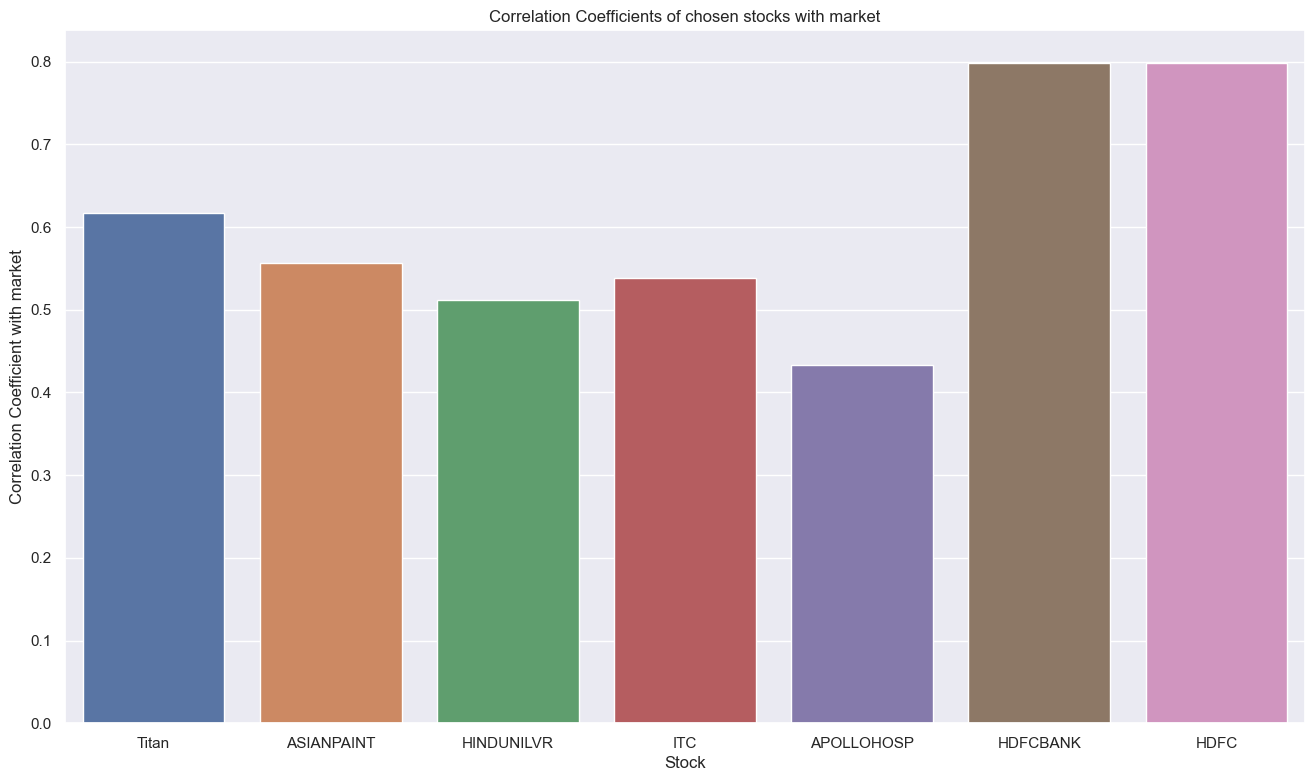

In [15]:
sns.barplot( x=list( corr_coeff.keys( ) ), y=list( corr_coeff.values( ) ) )
plt.xlabel( 'Stock' )
plt.ylabel( 'Correlation Coefficient with market' )
plt.title( 'Correlation Coefficients of chosen stocks with market' )
plt.show( )

# Calculate Beta for each stock

In [16]:
beta = {}

for stock in chosen_ones:
    beta[stock] = corr_coeff[stock] * train_std_return[stock] / train_std_return[index_one]

In [17]:
beta

{'Titan': 0.8972604950729887,
 'ASIANPAINT': 0.7116559363011656,
 'HINDUNILVR': 0.5813248949216447,
 'ITC': 0.7265037372778707,
 'APOLLOHOSP': 0.7563991185105943,
 'HDFCBANK': 1.096190130040211,
 'HDFC': 1.2748520471238902}

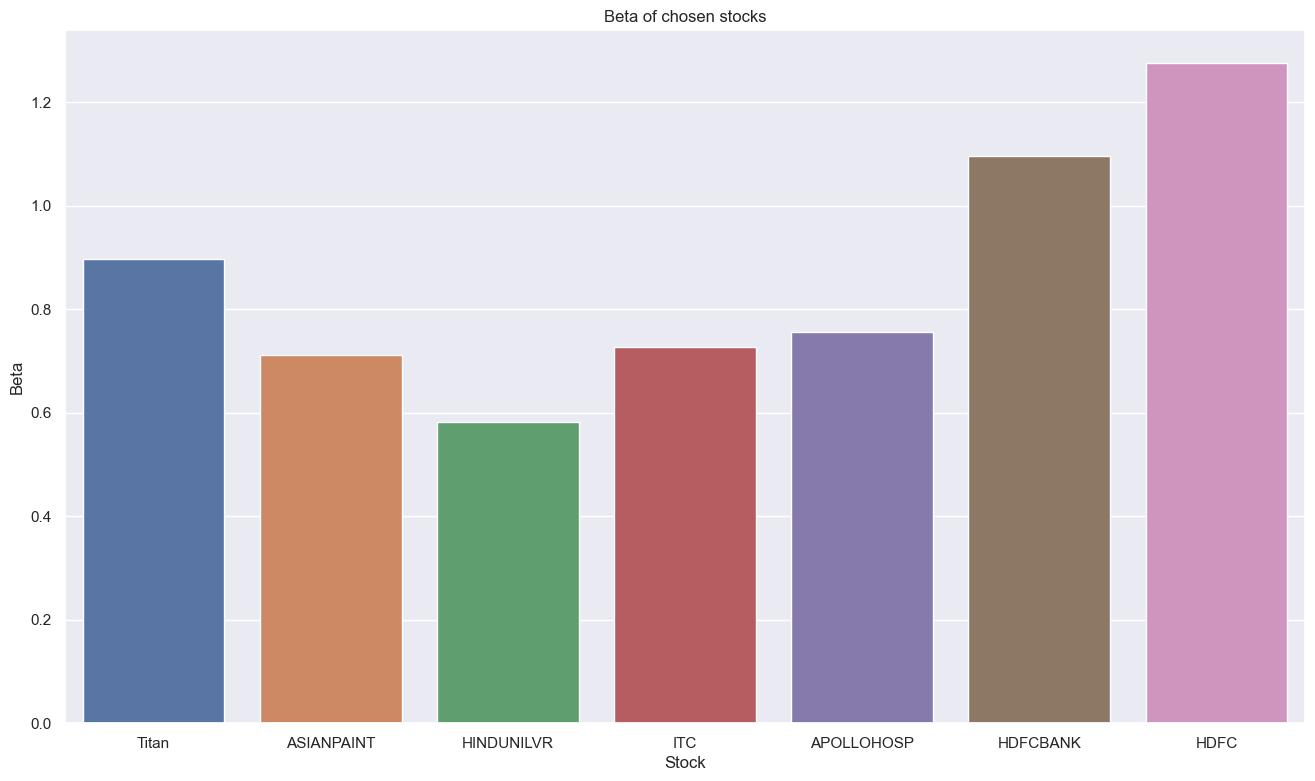

In [18]:
sns.barplot( x=list( beta.keys( ) ), y=list( beta.values( ) ) )
plt.xlabel( 'Stock' )
plt.ylabel( 'Beta' )
plt.title( 'Beta of chosen stocks' )
plt.show( )

# Calculate R2 Score for each stock

In [19]:
r2 = {}

for stock in chosen_ones:
    r2[stock] = r2_score( train_history[stock]['Return'], train_history[index_one]['Return'] )

In [20]:
r2

{'Titan': 0.3754346034859658,
 'ASIANPAINT': 0.25877394801743325,
 'HINDUNILVR': 0.12543701933552387,
 'ITC': 0.24834331452184977,
 'APOLLOHOSP': 0.1655713126322791,
 'HDFCBANK': 0.6318454258786076,
 'HDFC': 0.6070191572172083}

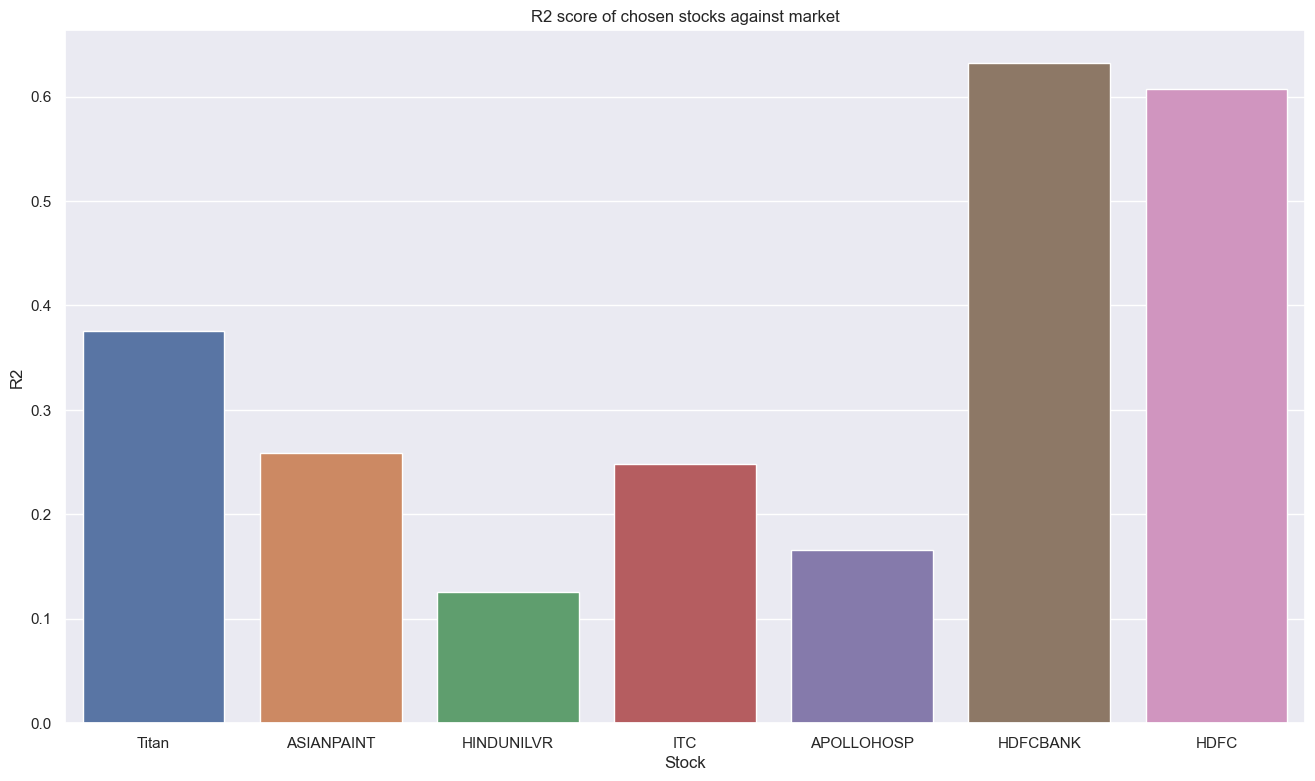

In [21]:
sns.barplot( x=list( r2.keys( ) ), y=list( r2.values( ) ) )
plt.xlabel( 'Stock' )
plt.ylabel( 'R2' )
plt.title( 'R2 score of chosen stocks against market' )
plt.show( )

# Summary graph

In [22]:
summary_df = pd.merge( 
                        pd.DataFrame( zip( r2.keys( ), r2.values( ) ), columns=['Stock', 'R2'] ),
                        pd.DataFrame( zip( beta.keys( ), beta.values( ) ), columns=['Stock', 'Beta'] ),
                        on=['Stock']
                    )

summary_df = summary_df.merge( pd.DataFrame( zip( corr_coeff.keys( ), corr_coeff.values( ) ), columns=['Stock', 'CorrCoeff'] ), on=['Stock'] )

summary_df = summary_df.merge( pd.DataFrame( zip( train_std_return.keys( ), train_std_return.values( ) ), columns=['Stock', 'std'] ), on=['Stock'] )

summary_df.head( 10 )

,Stock,R2,Beta,CorrCoeff,std
0,Titan,0.375435,0.897260,0.617224,0.021827
1,ASIANPAINT,0.258774,0.711656,0.556617,0.019197
2,HINDUNILVR,0.125437,0.581325,0.512425,0.017033
3,ITC,0.248343,0.726504,0.538466,0.020258
4,APOLLOHOSP,0.165571,0.756399,0.433702,0.026186
5,HDFCBANK,0.631845,1.096190,0.798124,0.020622
6,HDFC,0.607019,1.274852,0.797990,0.023987


In [23]:
graph_df = summary_df.melt( id_vars=['Stock'], value_vars=['R2', 'Beta', 'CorrCoeff', 'std'], var_name='Metric', value_name='Value' )
graph_df.head( )

,Stock,Metric,Value
0,Titan,R2,0.375435
1,ASIANPAINT,R2,0.258774
2,HINDUNILVR,R2,0.125437
3,ITC,R2,0.248343
4,APOLLOHOSP,R2,0.165571


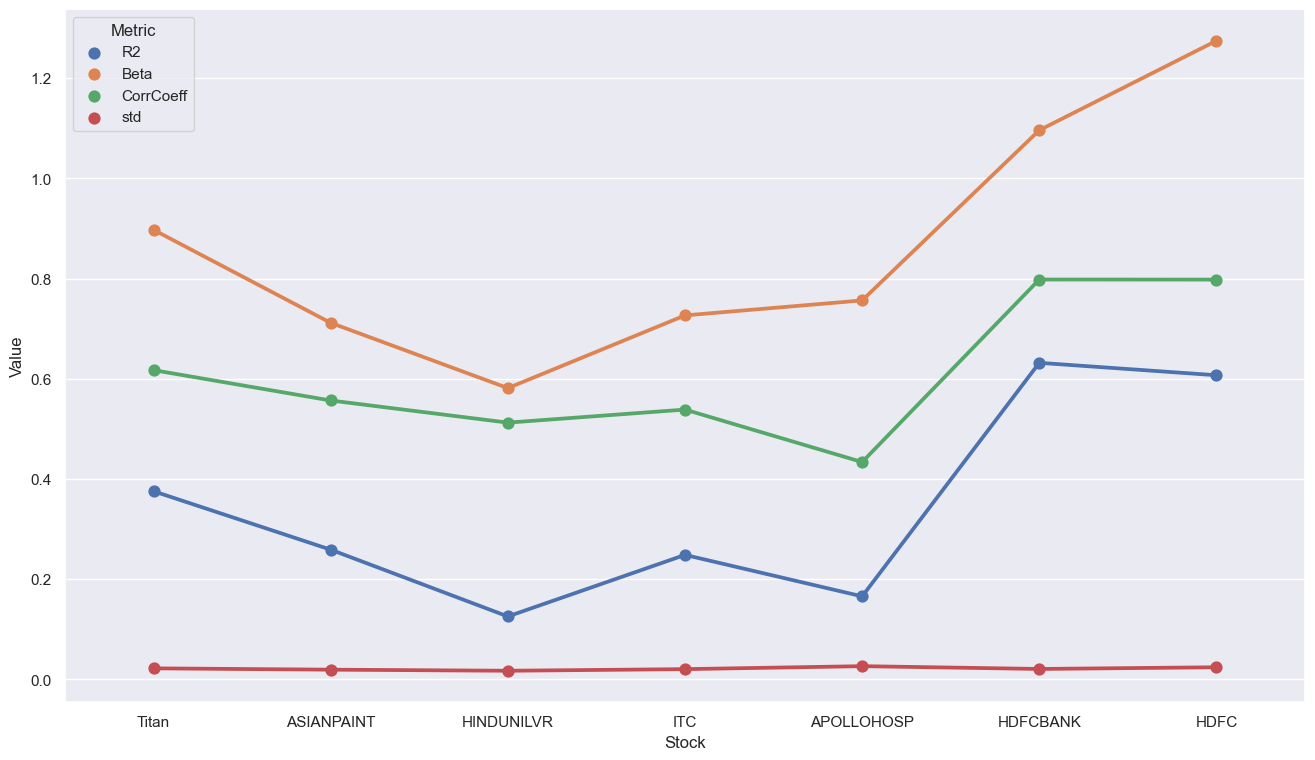

In [24]:
sns.pointplot( data=graph_df, x='Stock', y='Value', hue='Metric' )
plt.show( )

#### Low beta stocks have low correlation to market and low standard deviations - the opposite is true for high beta stocks

# Covariance Matrix

In [25]:
returns_df = pd.DataFrame( )

for stock in chosen_ones:
    returns_df[stock] = train_history[stock]['Return']

print( returns_df.shape )
returns_df.head( )

(620, 7)


,Titan,ASIANPAINT,HINDUNILVR,ITC,APOLLOHOSP,HDFCBANK,HDFC
0,0.018461,0.002434,0.024463,0.014283,0.021919,0.015452,-0.000718
1,0.001922,-0.020680,0.003196,-0.015966,-0.000371,-0.001583,0.017525
2,0.001946,0.026298,0.015889,0.009016,0.002754,-0.000896,0.019957
3,0.018427,0.002452,0.001429,0.002642,0.013783,0.007344,0.002250
4,0.022185,-0.020053,0.009670,0.009796,0.007690,0.008194,0.009669


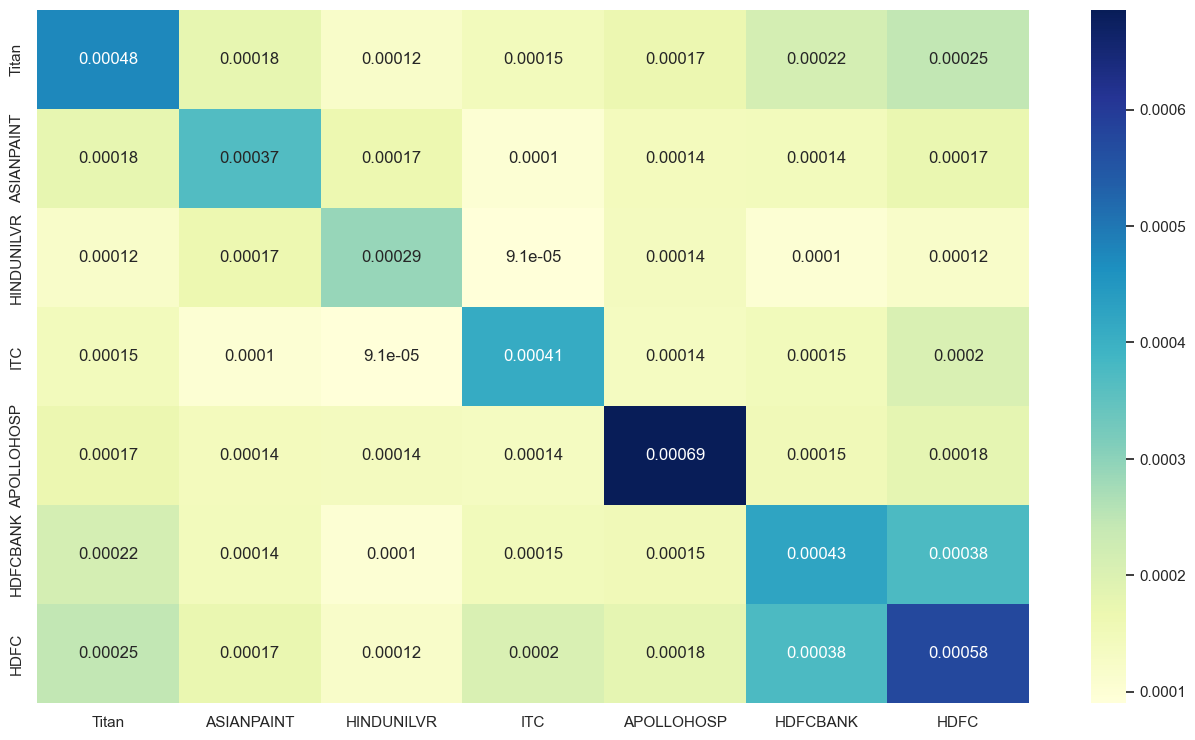

In [26]:
covar_df = returns_df.cov( )

sns.heatmap( covar_df, xticklabels=covar_df.columns, yticklabels=covar_df.columns, cmap='YlGnBu', annot=True )
plt.show( )

# Plotting Efficient Frontier

#### To plot efficient frontier - first we take a big number of portfolios with randomised stock weights (which always add up to 1) and record the standard deviation/return for each portfolio, then we plot the portfolios with maximum return for fixed standard deviations

In [27]:
graph_weights = []
graph_returns = []
graph_std = []


for iteration in range( 10000 ):
    # Generate random weights
    weights = np.random.random( len( chosen_ones ) )

    # Make sure weights add up to 1
    weights = weights / np.sum( weights )
    graph_weights.append( weights )

    # Calculate expected returns for this iteration
    returns = np.dot( weights, [ train_exp_return[stock] for stock in chosen_ones ] )
    graph_returns.append( returns )

    # Calculate standard deviation for this iteration
    std = np.sqrt( covar_df.mul( weights, axis=0 ).mul( weights, axis=1 ).sum( ).sum( ) )
    graph_std.append( std )

In [28]:
graph_df = pd.DataFrame( )

graph_df['Return'] = graph_returns
graph_df['std'] = graph_std

for idx, stock in enumerate( chosen_ones ):
    graph_df[stock] = np.asarray( graph_weights )[:,idx]

graph_df.head( )

,Return,std,Titan,ASIANPAINT,HINDUNILVR,ITC,APOLLOHOSP,HDFCBANK,HDFC
0,0.000714,0.014050,0.123744,0.133596,0.218997,0.135468,0.112875,0.143331,0.131989
1,0.000704,0.014715,0.007152,0.198458,0.175592,0.086817,0.131691,0.203934,0.196356
2,0.001007,0.014780,0.130377,0.046809,0.297830,0.126985,0.314073,0.077381,0.006545
3,0.000765,0.013977,0.190160,0.167686,0.163054,0.185621,0.097288,0.121565,0.074627
4,0.000538,0.015729,0.221919,0.006070,0.168456,0.109829,0.001271,0.305227,0.187228


In [33]:
frontier_df = pd.DataFrame( )
tol = 1e-4

for std in graph_df['std'].unique( ):
    # Get maximum/minimum return for current standard deviation
    if len( graph_df[ np.abs(graph_df['std'] - std)<=tol ] ) < 10:
        continue

    max_index = graph_df[ np.abs(graph_df['std'] - std)<=tol ]['Return'].idxmax( )
    # min_index = graph_df[ np.abs(graph_df['std'] - std)<=tol ]['Return'].idxmin( )

    frontier_df = pd.concat( [
                                frontier_df, 
                                graph_df.iloc[max_index:max_index+1,:], 
                                # graph_df.iloc[min_index:min_index+1,:]
                            ], ignore_index=True )

print( frontier_df.shape )
frontier_df.head( )

(9976, 9)


,Return,std,Titan,ASIANPAINT,HINDUNILVR,ITC,APOLLOHOSP,HDFCBANK,HDFC
0,0.000961,0.014110,0.194426,0.185629,0.192194,0.171726,0.202711,0.048390,0.004924
1,0.001098,0.014748,0.205649,0.220512,0.137920,0.069779,0.249972,0.087176,0.028992
2,0.001127,0.014872,0.256642,0.202483,0.203927,0.076122,0.256293,0.000999,0.003534
3,0.000930,0.014066,0.147263,0.194219,0.245622,0.118170,0.206302,0.055444,0.032981
4,0.001306,0.015768,0.249764,0.279648,0.033527,0.048979,0.314561,0.059559,0.013961


In [34]:
# Get the tip of efficient frontier
min_index = np.argmin( graph_df['std'] )

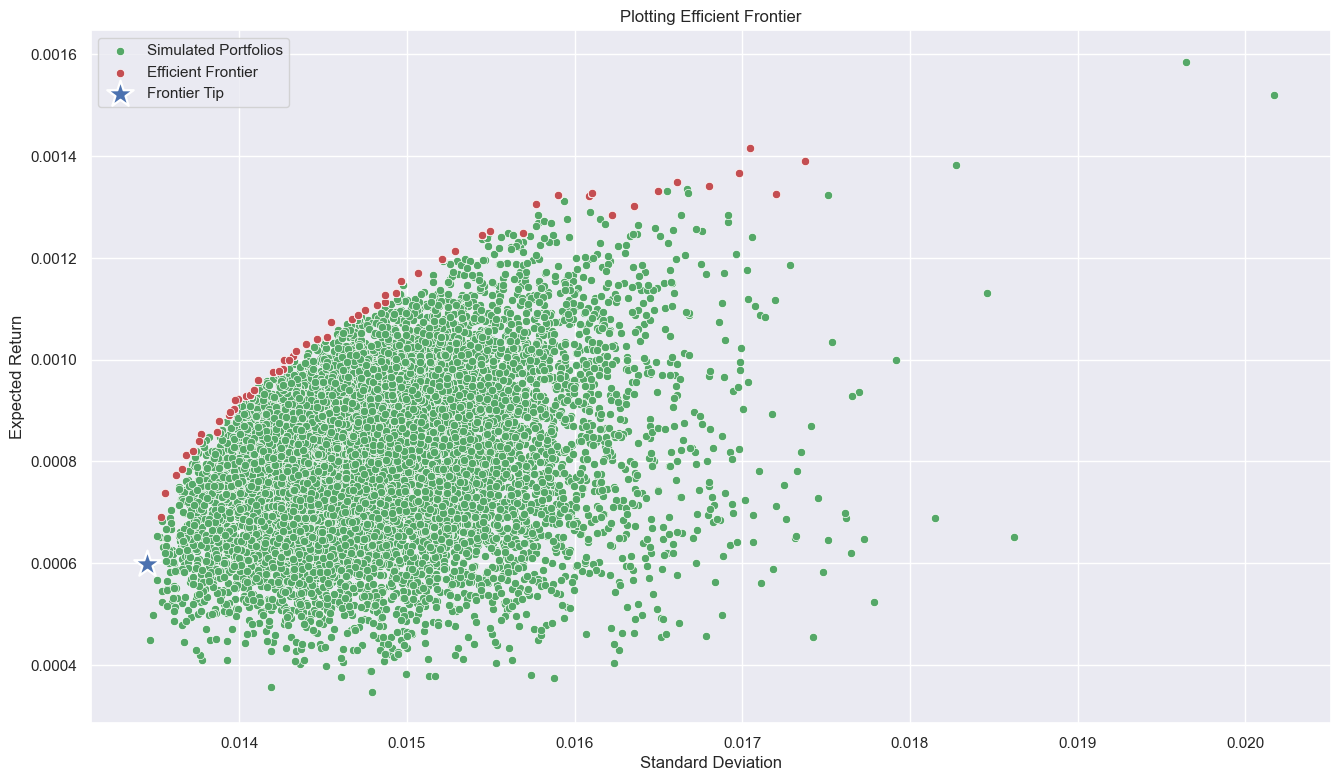

In [37]:
# Plot iteration outcome
sns.scatterplot( x=graph_df['std'], y=graph_df['Return'], marker='o', color='g', label='Simulated Portfolios' )

# Plot efficient frontier (and tip)
sns.scatterplot( x=frontier_df['std'], y=frontier_df['Return'], color='r', label='Efficient Frontier' )
sns.scatterplot( x=[graph_std[ min_index ]], y=[graph_returns[ min_index ]], marker='*', color='b', s=400, label='Frontier Tip'  )

plt.xlabel( 'Standard Deviation' )
plt.ylabel( 'Expected Return' )
plt.title( 'Plotting Efficient Frontier' )

plt.show( )

# My efficient portfolio

In [38]:
risk_factor = 0.0155

In [40]:
max_index = graph_df[ np.abs(graph_df['std'] - risk_factor)<=tol ]['Return'].idxmax( )

efficient_df = graph_df.iloc[max_index:max_index+1,:]

print( efficient_df.shape )
efficient_df.head( )

(1, 9)


,Return,std,Titan,ASIANPAINT,HINDUNILVR,ITC,APOLLOHOSP,HDFCBANK,HDFC
8787,0.001253,0.015497,0.265197,0.281846,0.102168,0.029263,0.282264,0.022558,0.016703


In [44]:
efficient_weights = list( efficient_df[chosen_ones].iloc[0] )
efficient_weights

[0.2651973598412323,
 0.2818459676687035,
 0.10216787173350961,
 0.029263112911695296,
 0.2822638174382553,
 0.02255845608311185,
 0.016703414323492264]

In [50]:
train_simulation = pd.DataFrame( )
test_simulation = pd.DataFrame( )

for stock in chosen_ones:
    train_simulation[stock] = train_history[stock]['Return']
    test_simulation[stock] = test_history[stock]['Return']

train_simulation['Return'] = train_simulation.dot( efficient_weights )
test_simulation['Return'] = test_simulation.dot( efficient_weights )

train_simulation['Date'] = train_history[stock]['Date']
test_simulation['Date'] = test_history[stock]['Date']

print( train_simulation.shape )
print( test_simulation.shape )
train_simulation.head( )

(620, 9)
(124, 9)


,Titan,ASIANPAINT,HINDUNILVR,ITC,APOLLOHOSP,HDFCBANK,HDFC,Return,Date
0,0.018461,0.002434,0.024463,0.014283,0.021919,0.015452,-0.000718,0.015023,2019-10-15 00:00:00+05:30
1,0.001922,-0.020680,0.003196,-0.015966,-0.000371,-0.001583,0.017525,-0.005307,2019-10-16 00:00:00+05:30
2,0.001946,0.026298,0.015889,0.009016,0.002754,-0.000896,0.019957,0.010905,2019-10-17 00:00:00+05:30
3,0.018427,0.002452,0.001429,0.002642,0.013783,0.007344,0.002250,0.009895,2019-10-18 00:00:00+05:30
4,0.022185,-0.020053,0.009670,0.009796,0.007690,0.008194,0.009669,0.004023,2019-10-22 00:00:00+05:30


In [53]:
print( 'Efficient Portfolio expected daily return in train period = ', train_simulation['Return'].mean( ) )
print( 'Market expected daily return in train period = ', train_history[index_one]['Return'].mean( ) )

print( )

print( 'Efficient Portfolio expected daily return in test period = ', test_simulation['Return'].mean( ) )
print( 'Market expected daily return in test period = ', test_history[index_one]['Return'].mean( ) )

Efficient Portfolio expected daily return in train period =  0.0012528282218885755
Market expected daily return in train period =  0.0007189702678596157

Efficient Portfolio expected daily return in test period =  0.000258757989550155
Market expected daily return in test period =  -0.00020886349667656508
